# Classification with Python

This assignment looks to answer the question of "Who will survive the Titanic?"

Data and competition information can be found here:
https://www.kaggle.com/c/titanic   
   
First, the necessary packages and data are read in.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error, roc_curve, auc

In [2]:
initial_train = pd.read_csv("/Users/tristanmoser/Files/Coding/Machine_Learning/HW3/train.csv")
initial_test = pd.read_csv("/Users/tristanmoser/Files/Coding/Machine_Learning/HW3/test.csv")

## Data Evaluation   
   
To get an idea of what data is available, I examine the training data. I will look at both continuous and categorical variables and evaluate them separately. I look at the distribution of the variables, missing values, and correlation with with whether the person survived or not.

In [3]:
initial_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
#Separate continuous and categorical variables for examination
train_non_cat = initial_train.select_dtypes(exclude = ['object'])
train_cat = initial_train.select_dtypes(include = ['object'])

### Categorical Data

In [5]:
#Overall descripion of variables
train_cat.describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Vande Walle, Mr. Nestor Cyriel",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [6]:
#Look at differences in Names, Tickets and Cabin
train_cat[['Name','Ticket','Cabin']].head()

,Name,Ticket,Cabin
0,"Braund, Mr. Owen Harris",A/5 21171,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
4,"Allen, Mr. William Henry",373450,NaN


From this initial evaluation of the categorical data, there are a few apparent problems that must be dealt with:
 - Name: Each name is unique, but each person appears to have a title
 - Ticket: Not all tickets share the same structure
 - Cabin: There are many missing observations
 
First, I will deal with the "Cabin" variable. There appears to be a sytematic problem with the variable. Because there are so many missing values in that variable, there is cause to drop it, because it will likely be hard to identify which Cabin each person was in.
      

In [7]:
def room_floor(x):
    """This function will isolate the cabin floor from the cabin room so that I can estimate survival by floor"""
    for room in x['Cabin']:
        x['Cabin'] = x['Cabin'].str.extract('([A-Za-z]+)', expand=True)

In [8]:
room_floor(initial_train)
room_floor(initial_test)

In [9]:
#Check the correlation of survival by Cabin floor
initial_train[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean()

,Cabin,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000


In [10]:
initial_train = initial_train.drop('Cabin',axis=1)
initial_test = initial_test.drop('Cabin',axis=1)

Now, I will look at the "Ticket" variable and what can be done to enhance its prediction properties. 

In [11]:
initial_train['Ticket'].head(5)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

After looking at some of the tickets, it looks like some tickets come with letters at the beginning while others do not. I will create a function that strips the ticket into just the first letter and test the correlation of survival.

In [12]:
def Ticket_Ident(ticket):
        """This function will strip the ticket variable of all numbers and return the first letter"""
        #get rid of "/" and "."
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        #make ticket into list by using the .split() command
        ticket = ticket.split()
        #remove white space
        ticket = map(lambda t : t.strip() , ticket)
        #remove numbers and only take letters
        ticket = ''.join(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'No_Letter'
    

initial_train['Ticket'] = initial_train['Ticket'].map(Ticket_Ident)
initial_test['Ticket'] = initial_test['Ticket'].map(Ticket_Ident)

In [13]:
initial_train[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,A,0.068966
1,C,0.340426
2,F,0.571429
3,L,0.250000
4,No_Letter,0.384266
5,P,0.646154
6,S,0.323077
7,W,0.153846


Finally, I look at the issues with the "Name" variable. Because each name contains a broader title, I extract the title from each name and examine the correlation between the title and survival.

In [14]:
def titles(x):
    """This function will extract the Title from each name and return it in a new column 'Title'"""
    x['Title'] = x['Name']
    for name in x['Title']:
        x['Title'] = x['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [15]:
#Apply function
titles(initial_train)
titles(initial_test)

In [16]:
#Verify that the function correctly pulled out the Title
initial_train[['Title','Name']].head()

,Title,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"


In [17]:
#Examine relationship between Title and Survival
initial_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Countess,1.000000
3,Don,0.000000
4,Dr,0.428571
5,Jonkheer,0.000000
6,Lady,1.000000
7,Major,0.500000
8,Master,0.575000
9,Miss,0.697802


It is apparent that we now have some predictive power using these titles instead of the specific names. I will now drop the "Name" variable as it is of no further use.

In [18]:
initial_train = initial_train.drop('Name',axis=1)
initial_test = initial_test.drop('Name',axis=1)

It will also be informative to see how survival relates to gender

In [19]:
initial_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


### Continuous Variables

In [20]:
train_non_cat.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



From the previous description of the coninuous variables, it is clear that there is a missing value problem with "Age". There are almost 200 observations missing this variable, but it seems like that could be a random problem. In this case, I will impute the missing age values using the median age corresponding the person's gender.

In [21]:
#Impute missing ages by median age based on gender from train data
genders = ['male','female']
for gender in genders:
    age_to_impute = initial_train.groupby('Sex')['Age'].median()[genders.index(gender)]
    initial_train.loc[(initial_train['Age'].isnull()) & (initial_train['Sex'] == gender), 'Age'] = age_to_impute
    
    initial_test.loc[(initial_test['Age'].isnull()) & (initial_test['Sex'] == gender), 'Age'] = age_to_impute

#### Visualization   
   
I will now visualize the continuous variables to examine their distributions and see where features can be created or improved. The variables are split according to their measurement sizes so that the graphs can be accurately assessed.   
   
##### Survived, Pclass, SibSp, and Parch Variables

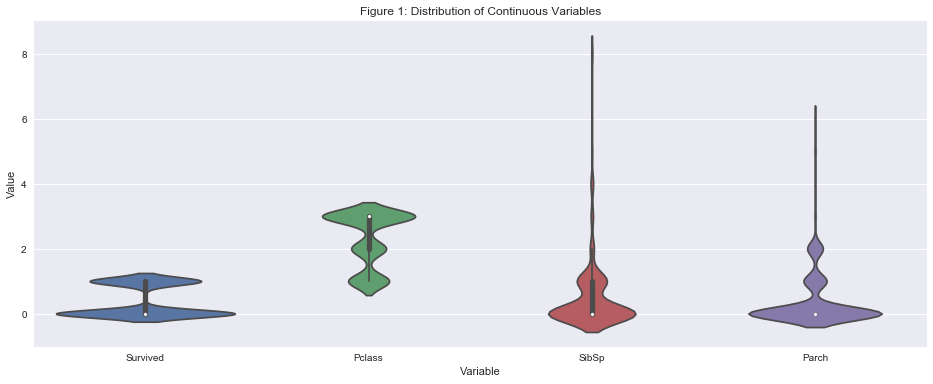

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data=train_non_cat[['Survived','Pclass','SibSp','Parch',]])
plt.title('Figure 1: Distribution of Continuous Variables')
plt.ylabel('Value')
plt.xlabel('Variable')

Upon examination, the "SibSp" and "Parch" variables appear to be have high concentrations of people with few siblings and/or children. Because of this, I look at the relationship between them and survival.

In [23]:
initial_train[['SibSp','Parch', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Parch,Survived
0,0,0.185855,0.345395
1,1,0.655502,0.535885
2,2,0.642857,0.464286
3,3,1.312500,0.250000
4,4,1.500000,0.166667
5,5,2.000000,0.000000
6,8,2.000000,0.000000


The observed relationship suggests that having some form of a family member with you on the ship increases the likelihood of survival. To implement this observation, I create a new variable "Fam" that will add "SibSp" and "Parch". Then, I create another variable "Family" that is 0 if the person has no family with them and 1 if they do.

In [24]:
def family(x):
    """This function will create an indicator variable for whether the person has family on board or not"""
    for aa in x:
        x['Fam'] = x['SibSp'] + x['Parch']
    x['Family'] = 0
    x.loc[x['Fam'] >= 1, 'Family'] = 1
    

In [25]:
family(initial_train)
#drop other family variables
initial_train = initial_train.drop(['SibSp','Parch','Fam'],axis=1)
#drop other family variables
family(initial_test)
initial_test = initial_test.drop(['SibSp','Parch','Fam'],axis=1)

In [26]:
initial_train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,0,0.303538
1,1,0.505650


##### Age and Fare Variables

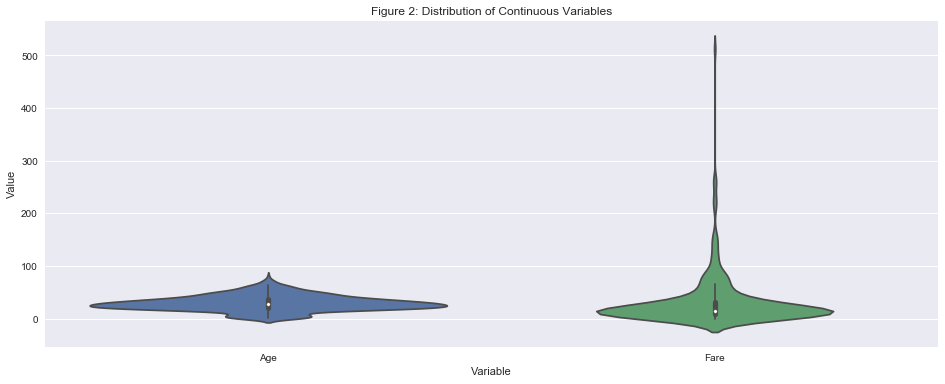

In [27]:
fig, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data=train_non_cat[['Age','Fare']])
plt.title('Figure 2: Distribution of Continuous Variables')
plt.ylabel('Value')
plt.xlabel('Variable')

The "Fare" variable is highly concentrated at a relatively low price of about $30. There are, however, a decent amount of outliers with higher prices. To better group the Fares, I create a new variable "Fare_cat" that groups the person's Fare relative to other Fares.

In [28]:
def fares(x):
    """This function will categorize the Fare into respective bins"""
    x['Fare_cat'] = "Low"
    x.loc[(x['Fare'] >=float(100.0)), 'Fare_cat'] = "Very High"
    x.loc[(x['Fare'] <float(100.0)) & (x['Fare'] >=float(75.0)), 'Fare_cat'] = "High"
    x.loc[(x['Fare'] <float(75.0)) & (x['Fare'] >=float(40.0)), 'Fare_cat'] = "Mid"
    x.loc[(x['Fare'] <float(40.0)), 'Fare_cat'] = "Low"
    

In [29]:
fares(initial_train)
#Drop old fare variable
initial_train = initial_train.drop('Fare',axis=1)
fares(initial_test)
#Drop old fare variable
initial_test = initial_test.drop('Fare',axis=1)

In [30]:
#Analyze relationship of Fare category and survival
initial_train[['Fare_cat', 'Survived']].groupby(['Fare_cat'], as_index=False).mean()

,Fare_cat,Survived
0,High,0.795455
1,Low,0.320280
2,Mid,0.493671
3,Very High,0.735849


## Prepare Data for Modeling   
   
Now that the features have been processed, the data must now be prepared for modeling. To do this, I create dummy variables, verify that the train and test sets contain the same variables, and normalize them using the StandardScaler.

In [31]:
#Get Dummy Variables
train = pd.get_dummies(initial_train)
test = pd.get_dummies(initial_test)

##### Verify Variables

In [32]:
#Gather list of all variables in train
train_columns = []
for abc in train:
    train_columns.append(abc)

#Gather list of all variables in test
test_columns = []
for xyz in test:
    test_columns.append(xyz)

In [33]:
#Generate list of variables in Train but not in Test
uncommon = [item for item in train_columns if item not in test_columns and item != 'Survived']

In [34]:
uncommon

['Title_Capt',
 'Title_Countess',
 'Title_Don',
 'Title_Jonkheer',
 'Title_Lady',
 'Title_Major',
 'Title_Mlle',
 'Title_Mme',
 'Title_Sir']

In [35]:
#Generate empty variables in Test from Train set
for title in uncommon:
    test[title] = 0

In [36]:
#Create list of variables in Test but not in Train
uncommon = [item for item in test_columns if item not in train_columns]

In [37]:
uncommon

['Title_Dona']

In [38]:
train['Title_Dona'] = 0

In [39]:
#test.isnull().sum()

In [40]:
#test = test.fillna(train['Fare_cat'].mean())

##### Split and Standardize

In [41]:
#Isolate target and predictors
target = train['Survived']
predictors = train.drop('Survived',axis=1)
#Split train set for cross validation
x_train, x_cv, y_train, y_cv = train_test_split(predictors, target, test_size=0.3, random_state=42)

In [42]:
scaler = StandardScaler()
#fit scaler with train data
scaler.fit(x_train)
#transform using the train data fit
scaled_train = scaler.transform(x_train)
scaled_cv = scaler.transform(x_cv)

In [43]:
#transfrom test from train data fit
scaled_test = scaler.transform(test)

## Modeling   
   
With the data now prepared, I begin modeling to predict survival. The following models will be examined:
 - Logistic Regression
 - K-nearest Neighbors
 - Random Forest
 - Gradient Boosing   
    
The following evaluation function will be used to asses the usefulness of the model.

In [44]:
def evaluate(x):
    x.fit(scaled_train,y_train)
    train_pred = x.predict(scaled_train)
    cv_pred = x.predict(scaled_cv)
    print("Classification Summary:")
    print(classification_report(y_cv, cv_pred))
    print("Accuracy CV:")
    print(accuracy_score(y_cv,cv_pred))
    print("Accuracy Train:")
    print(accuracy_score(y_train,train_pred))

### Logistic Regression

In [45]:
logreg = linear_model.LogisticRegression()
evaluate(logreg)

Classification Summary:
             precision    recall  f1-score   support

          0       0.83      0.87      0.85       157
          1       0.80      0.74      0.77       111

avg / total       0.82      0.82      0.82       268

Accuracy CV:
0.817164179104
Accuracy Train:
0.825040128411


### K-nearest Neighbors

In [46]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": [2,3,4,5,6,7,8],"weights": ['uniform','distance'],"p": [2,3,4]}
gridsearch = GridSearchCV(knn, param_grid = parameters, scoring='accuracy')
evaluate(gridsearch)

Classification Summary:
             precision    recall  f1-score   support

          0       0.74      0.91      0.82       157
          1       0.82      0.56      0.66       111

avg / total       0.77      0.76      0.75       268

Accuracy CV:
0.764925373134
Accuracy Train:
0.874799357945


### Random Forest

In [47]:
forest = RandomForestClassifier()
params = {"n_estimators": [200,300,400, 450, 500, 600],"max_depth": [8,10,12,14,15,16]}
gridsearch2 = GridSearchCV(forest, param_grid = params, scoring='accuracy')
evaluate(gridsearch2)

Classification Summary:
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       157
          1       0.81      0.71      0.76       111

avg / total       0.81      0.81      0.81       268

Accuracy CV:
0.809701492537
Accuracy Train:
0.980738362761


In [48]:
forest2 = RandomForestClassifier(n_estimators = 6000, max_depth = 4)
evaluate(forest2)

Classification Summary:
             precision    recall  f1-score   support

          0       0.81      0.85      0.83       157
          1       0.78      0.72      0.75       111

avg / total       0.80      0.80      0.80       268

Accuracy CV:
0.798507462687
Accuracy Train:
0.817014446228


### Gradient Boosting

In [49]:
boost = GradientBoostingClassifier()
gridsearch3 = GridSearchCV(boost, {"learning_rate": [.1, .01, .005, .05], "n_estimators": [50, 100, 500, 800], 
                                'max_depth': [2,3, 4, 5]}, scoring='accuracy')
evaluate(gridsearch3)

Classification Summary:
             precision    recall  f1-score   support

          0       0.74      0.97      0.84       157
          1       0.92      0.51      0.66       111

avg / total       0.81      0.78      0.76       268

Accuracy CV:
0.779850746269
Accuracy Train:
0.805778491172


In [50]:
boost2 = GradientBoostingClassifier(learning_rate=.01,n_estimators=150,max_depth=3)
evaluate(boost2)

Classification Summary:
             precision    recall  f1-score   support

          0       0.78      0.94      0.86       157
          1       0.89      0.63      0.74       111

avg / total       0.83      0.81      0.81       268

Accuracy CV:
0.813432835821
Accuracy Train:
0.836276083467


## Test Prediction and Kaggle Submission

In [51]:
IDs = test['PassengerId']

test_pred = gridsearch3.predict(scaled_test)

In [52]:
Output = pd.DataFrame({"PassengerId": IDs, "Survived": test_pred})
Output.to_csv("/Users/tristanmoser/files/coding/machine_learning/HW3/Kaggle_sub2.csv",index=False)

## Conclusion